In [20]:
# Initial imports
import networkx as nx
import matplotlib.pyplot as plt
import random
from random import shuffle
from math import *
import numpy as np
%matplotlib inline

In [21]:
# Loading the network
observed = nx.read_gml('netscience.gml',label="id")
observed = nx.Graph(observed, name="Observed Links")

random.seed(1000)

probe_size = int(0.3*(observed.number_of_edges()))
probe_edge_set = random.sample(list(observed.edges()),probe_size)

training = nx.Graph(observed, name="Training Links")
for i in probe_edge_set:
    training.remove_edge(i[0],i[1])

print(nx.info(observed), "\n")
print(nx.info(training), "\n")
print("Probe Edge Set\nNumber of edges:", len(probe_edge_set))

Name: Observed Links
Type: Graph
Number of nodes: 1589
Number of edges: 2742
Average degree:   3.4512 

Name: Training Links
Type: Graph
Number of nodes: 1589
Number of edges: 1920
Average degree:   2.4166 

Probe Edge Set
Number of edges: 822


In [22]:
def _apply_prediction(G, f, ebunch=None):
    """Applies the given function to each edge in the specified iterable of edges.

    'G' is an instance of :class:'networkx.Graph'.

    'f' is a function on two inputs, each of which is a node in the graph.
    The function can return anything, but it should return a value 
    representing a prediction of the score of a "link" joining the two nodes.

    'ebunch' is an iterable of pairs of nodes. If not specified, all non-edges in the graph 'G' will be used.
    """
    if ebunch is None:
        ebunch = nx.non_edges(G)
    return [(u, v, f(u, v)) for u, v in ebunch]

In [23]:
# ====================================================
# CALCULATING/PLOTTING AUC : AREA UNDER ROC CURVE
# ====================================================
def AUC(score_probe,score_non_existent):
    N = min(len(score_probe),len(score_non_existent))
    shuffle(score_probe)
    shuffle(score_non_existent)
    
    n1 = n2 = n3 = 0
    for i in range(N):
        probe_edge = score_probe[i]
        non_ex_edge = score_non_existent[i]
        if probe_edge[2] > non_ex_edge[2]:
            n1 += 1
        elif probe_edge[2] < non_ex_edge[2]:
            n3 += 1
        else:
            n2 += 1

    tp = tn = n1 + n2/2
    fp = fn = N - tp
    
    AUC = 0
    if N > 0:
        AUC = tp / N
    return AUC   


def plot(mins,maxs,means,vals,names):
#     fig,(sub,box) = plt.subplots(ncols = 2, figsize = (15,5))
    
    fig = plt.figure(1)
    sub = fig.add_subplot(111)
    fig2 = plt.figure(2)
    box = fig2.add_subplot(111)
    
    tests = len(names)
    iters = 0
    if tests > 0:
        iters = len(vals[0])

#   Line Plot
    for i in range(tests):
        name = names[i]
        l = vals[i]
        sub.plot(range(1,len(l)+1),l,'-o',label=name)
        
    sub.set_title("Area Under ROC Curve")
    sub.set_xlabel('Iteration')
    sub.set_ylabel('AUC')
    sub.set_xticks(np.arange(1, iters+1, 1.0))
    sub.set_yticks(np.arange(0, 1.1, 0.1))

    sub.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#     sub.legend(loc='center left', bbox_to_anchor=(0.5, -0.4))
    sub.axhline(0.5, linestyle='--', color='k')
    sub.yaxis.grid()

#   Box Plot
    box.set_title("Area Under ROC Curve")
    box.set_ylabel('AUC')
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xticks(rotation=90)
    box.axis(ymin=0,ymax=1)
    box.axhline(0.5, linestyle='--', color='k')
    box.yaxis.grid()

    box.errorbar(names, means, fmt='sb', lw=3)
    box.errorbar(names, means, 
                 [np.array(means)-np.array(mins), np.array(maxs)-np.array(means)],
                 fmt='.b', ecolor='blue', lw=1,capsize=3,capthick=3,ms=9,markerfacecolor='none',mew=1)
    plt.show()
    

def plotAUC(metrics,N=100,T=10):
    mins = []
    maxs = []
    means = []
    names = []
    vals = []
    for name,f in metrics.items():
        l = []
        for i in range(T):
            pro = random.sample(probe_edge_set, N)
            score_probe = f(training, pro)
            non_e = random.sample(list(nx.non_edges(observed)), N)
            score_non_existent = f(training, non_e)

            l += [AUC(score_probe,score_non_existent)]

        AUCrange = (min(l), max(l), sum(l)/float(len(l)))
        vals.append(l)
        mins.append(AUCrange[0])
        maxs.append(AUCrange[1])
        means.append(AUCrange[2])
        names.append(name)
        print(name,':',AUCrange)

    plot(mins,maxs,means,vals,names)

# Crisp Logic for Link Prediction
---
## Similarity Metrics
* Graph Distance
* Common Neighbours
* Jaccard's Coefficient
* Adamic/Adar (Frequency-Weighted Common Neighbours)
* Resource Allocation Index
* Preferential Attachment
* Katz (Exponentially Damped Path Counts)
* Weighted Clustering Coefficient

In [24]:
# ====================================================
# CRISP LOGIC : SIMILARITY METRICS
# ====================================================
def graph_distance(G, ebunch=None):
    """Compute the score based on shortest path length (number of nodes in the path).
    """
    def predict(u, v):
        try:
            return -nx.shortest_path_length(G,source=u,target=v)
        except:
            return -observed.number_of_nodes()
    return _apply_prediction(G, predict, ebunch)


def path_length(G, ebunch=None):
    """Compute the score based on shortest path length (sum of weights).
    """
    def predict(u, v):
        try:
            return -nx.shortest_path_length(G,source=u,target=v,weight='value')
        except:
            return -observed.number_of_nodes()
    return _apply_prediction(G, predict, ebunch)


def common_neighbors(G, ebunch=None):
    """Compute the Common Neighbours of all node pairs in ebunch.
    """
    def predict(u, v):
        return len(list(nx.common_neighbors(G, u, v)))
    return _apply_prediction(G, predict, ebunch)


def jaccard_coefficient(G, ebunch=None):
    """Compute the Jaccard coefficient of all node pairs in ebunch.
    """
    def predict(u, v):
        union_size = len(set(G[u]) | set(G[v]))
        if union_size == 0:
            return 0
        return len(list(nx.common_neighbors(G, u, v))) / union_size
    return _apply_prediction(G, predict, ebunch)


def adamic_adar_index(G, ebunch=None):
    """Compute the Adamic-Adar index of all node pairs in ebunch.
    """
    def predict(u, v):
        return sum(1 / log(G.degree(w)) for w in nx.common_neighbors(G, u, v))
    return _apply_prediction(G, predict, ebunch)


def resource_allocation_index(G, ebunch=None):
    """Compute the resource allocation index of all node pairs in ebunch.
    """
    def predict(u, v):
        return sum(1 / G.degree(w) for w in nx.common_neighbors(G, u, v))
    return _apply_prediction(G, predict, ebunch)


def preferential_attachment(G, ebunch=None):
    """Compute the preferential attachment score of all node pairs in ebunch.
    """
    def predict(u, v):
        return G.degree(u) * G.degree(v)
    return _apply_prediction(G, predict, ebunch)


def clustering_coefficient(G, ebunch=None):
    """Compute the Clustering Coefficient score of all node pairs in ebunch.
    """
    def predict(u, v):
        return nx.clustering(G,u) + nx.clustering(G,v)
    return _apply_prediction(G, predict, ebunch)


def weighted_clustering_coefficient(G, ebunch=None):
    """Compute the Weighted Clustering Coefficient score of all node pairs in ebunch.
    """
    def predict(u, v):
        return nx.clustering(G,u,weight='value') + nx.clustering(G,v,weight='value')
    return _apply_prediction(G, predict, ebunch)

# Fuzzy Logic for Link Prediction
---
## Clustering Coefficient
An important concept that shows how much the neighbors of a node are related to each other is the clustering coefficient (CC). This measure calculates the number of triangles over the number of possible triangles related to the node. CC is based on the clique concept. If S shows a clique in the graph, then the following criteria can define the clique: 
* C1 : “Most of the elements in S are closely connected.” 
* C2 : “None of the elements in S are too far from the others.” 
* C3 : “No element not on the clique is better connected to the members of a clique than any element in the clique.” 

In the above-mentioned criteria, there are some functions that should be defined as fuzzy terms.

### Close

In [25]:
def Close(G,u,v,path=None):
    '''
    Takes in a clique G and two of its nodes
    Returns the "Close" value of the two nodes
    '''
    if not path:
        try:
            path = nx.shortest_path(G,source=u,target=v,weight='value')
        except:
            return 0
    
    q = len(path)-1
    path_len = 0.0
    for i in range(q):
        path_len += G[path[i]][path[i+1]]['value']
    
    if q < 2:
        return 1
    elif q > 3:
        return 0
    else:
        return path_len/float(2.0*(pow(10,q-2)))

### Most

In [26]:
def Most(G,nodes,u,alpha=0.3,beta=0.7):
    '''
    Returns the "Most" value of the given node of the clique
    '''
    if len(nodes) == 0:
        return 0
    
    p = 0
    for v in nodes:
        p += Close(G,u,v)
    p /= float(len(nodes))
    
    if p <= alpha:
        return 0
    elif p <= beta:
        return (p-alpha)/float(beta-alpha)
    else:
        return 1

### Not Far

In [27]:
def R(G,x,y,k):
    '''
    Takes in Graph G, source x, target y and path length k    
    Returns R
    R = 1 if there exists a path containing atleast 'k' links
    R = 0 else
    '''
    paths = nx.all_simple_paths(G,source=x,target=y,cutoff=k)
    for path in paths:
        if len(path) >= k:
            return 1
    return 0

def Far(k,alpha=1.5,beta=3.5):
    '''
    Heaviside Step Function that denotes if a certain path length is "far" or not
    '''
    if k <= alpha:
        return 0
    elif k <= beta:
        return (k-alpha)/float(beta-alpha)
    else:
        return 1

def NotFar(G,x,y,n):
    '''
    Returns the NotFar(x,y) value which is given by the formula:
    NotFar(x,y) = Max { 
                        R(x,y)[at k] AND 1-Far(k) 
                    } over k, 1<=k<=n 
    '''
    notfar = 0
    for k in range(1,n):
        if R(G,x,y,k) == 0:
            break
        notfar = max(notfar,1.0-Far(k))
    return notfar

### First Criterion
**“Most of the elements in S are closely connected.”** In the first criterion, the first fuzzy term is the concept of close,  which  means  how  much  two  nodes  are  closely connected. The close concept can be defined as a path with a minimum length that connects two nodes to each other.

In [28]:
def C1(G,nodes,x):
    return Most(G,nodes,x)

### Second Criterion
**“None of the elements in S are too far from the others.”** In the second criterion of the cluster, there are Far and Not Far concepts.

In [29]:
def C2(G,nodes,x):
    c2 = 1
    for y in nodes:
        c2 = min(c2,NotFar(G,x,y,len(nodes)))
    return c2

### Third Criterion
**“No element not on the clique is better connected to the members of a clique than any element in the clique.” ** In the third criterion, every node out of the cluster of considered nodes should not be close to most of the nodes in the cluster.

In [30]:
def C3(G,nodes,x):
    rest_list = random.sample(G.nodes(),2*len(nodes))
    rest_set = set(rest_list) - set(nodes+[x])
    rest_list = random.sample(list(rest_set),len(nodes))
    
    m1 = Most(G,nodes,x)
    m2 = Most(G,list(rest_list),x)
    
    if m1 > m2:
        return 1
    else:
        return 0

In [31]:
# ====================================================
# CLIQUES
# ====================================================
cliques = nx.cliques_containing_node(training,nodes=list(range(observed.number_of_nodes())))
for key,c in cliques.items():
    c = sorted(c, key = lambda x : -len(x))
    cliques[key] = c
print("Cliques Stored")

Cliques Stored


In [32]:
# ====================================================
# FUZZY CLUSTERING COEFFICIENT
# ====================================================
def fcc(G,x):
    nodes = cliques[x][0]
    nodes = list(set(nodes) - set([x]))
    cc = min(C1(G,nodes,x),C2(G,nodes,x),C3(G,nodes,x))
    return cc

def fuzzy_clustering_coefficient(G, ebunch=None):
    """Compute the Fuzzy Clustering Coefficient score of all node pairs in ebunch.
    """
    def predict(u, v):
        return fcc(G,u)+fcc(G,v)
    return _apply_prediction(G, predict, ebunch)

In [33]:
# ====================================================
# FUZZY CLUSTER OVERLAP INDEX
# ====================================================
def cluster_x(G,x,K,N):
    cluster_x = 0.0
    nodes = random.sample(range(G.number_of_nodes()),N)
    for node in nodes:
        if node == x:
            continue
        paths = nx.all_simple_paths(G,source=x,target=node,cutoff=K)
        for path in paths:
            path_len = 0.0
            for i in range(len(path)-1):
                path_len += G[path[i]][path[i+1]]['value']
            cluster_x += path_len
    cluster_x = abs(cluster_x)
    return cluster_x


def oi(G,u,v,K=5,N=100):
    paths = nx.all_simple_paths(G,source=u,target=v,cutoff=K)
    
    close_sum = 0.0
    for path in paths:
        close_sum += Close(G,u,v,path)

    cluster_u = cluster_x(G,u,K,N)
    cluster_v = cluster_x(G,v,K,N)
    
    if cluster_u + cluster_v > 0:
        return close_sum / float(cluster_u + cluster_v)
    return 0


def fuzzy_cluster_overlap(G, ebunch=None):
    """Compute the Fuzzy Cluster Overlap score of all node pairs in ebunch.
    """
    def predict(u, v):
        return oi(G,u,v,K=3,N=120)
    return _apply_prediction(G, predict, ebunch)

Graph Distance : (0.87, 0.905, 0.8815)
Path Length : (0.875, 0.935, 0.8949999999999999)
Common Neighbors : (0.835, 0.91, 0.8735000000000002)
Jaccard Coefficient : (0.83, 0.895, 0.866)
Adamic/Adar Index : (0.845, 0.91, 0.8765000000000001)
Resource Allocation Index : (0.835, 0.905, 0.8744999999999999)
Preferential Attachment : (0.595, 0.725, 0.6615)
Clustering Coefficient : (0.455, 0.595, 0.5235)
Weighted Clustering Coefficient : (0.365, 0.52, 0.43900000000000006)


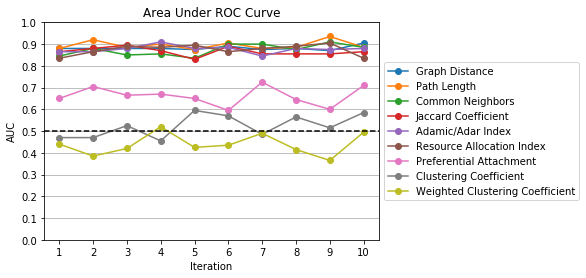

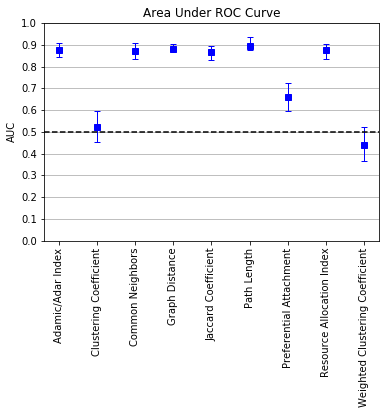

In [34]:
metrics = {
    "Graph Distance" : graph_distance,
    "Path Length" : path_length,
    "Common Neighbors" : common_neighbors,
    "Jaccard Coefficient" : jaccard_coefficient,
    "Adamic/Adar Index" : adamic_adar_index,
    "Resource Allocation Index" : resource_allocation_index,
    "Preferential Attachment" : preferential_attachment,
    "Clustering Coefficient" : clustering_coefficient,
    "Weighted Clustering Coefficient" : weighted_clustering_coefficient,
}
plotAUC(metrics)

CC : (0.48, 0.595, 0.5355)
WCC : (0.315, 0.585, 0.43100000000000005)
FCC : (0.505, 0.625, 0.5589999999999999)
FCO : (0.785, 0.81, 0.7969999999999999)


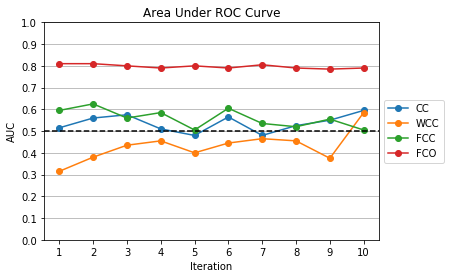

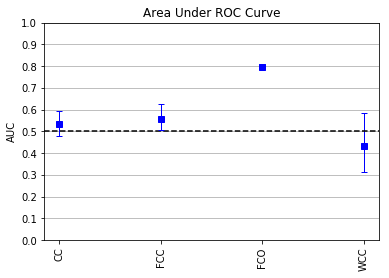

In [35]:
metrics = {
    "CC" : clustering_coefficient,
    "WCC" : weighted_clustering_coefficient,
    "FCC" : fuzzy_clustering_coefficient,
    "FCO" : fuzzy_cluster_overlap,
}
plotAUC(metrics,N=100,T=10)